# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy

# Helper functions

In [2]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [3]:
def get_best_matches(img1, img2, num_matches=300):
    """
    Descriptions: find putative matches for descriptors in two images
    Inputs:
        img1: first image to investigate
        img2: second image to investigate
        num_matches: number of best matches to find
    Returns:
        pt_pairs: np.ndarray with shape (num_matches, 4)
            where the `num_matches` best matches are listed in an sorted order.
            the first two columns are for pixel coordinates in img1, and the others are corresponding for img2 correspondingly.
    """
    # Get SIFT keypoints and the corresponding descriptors
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in the two images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # From `dist`, find `num_matches` smallest sorted indices
    # `indices` has the size of (num_matches, 2) where each row is (row, col) for `dist`
    indices_raw = dist.ravel().argsort()[:num_matches]
    indices = np.stack(np.unravel_index(indices_raw, dist.shape)).T

    # Find corresponding pixel location in `kp1` and `kp2`
    pt_pairs = np.empty((num_matches, 4))
    for i, idx in enumerate(indices):
        pt_pairs[i, 0:2] = kp1[idx[0]].pt
        pt_pairs[i, 2:4] = kp2[idx[1]].pt

    return pt_pairs

def ransac(pt_pairs, num_iteration=100, threshold=1):
    """
    Descriptions: find homography estimation between two images using RANSAC
    Inputs:
        pt_pairs: np.ndarray with shape (N, 4)
            where the first two columns stand for pixel coordinates for descriptors in img1, and others in img2 correspondinly
        num_iteration: number of iteration for RANSAC (in slide, a variable denoted as `N`)
        threshold: distance threshold for choosing inliers. (in slide, a variable denoted as `\delta`)
    Remark: number of samples (in slide, a variable denoted as `N`) is fixed to be 4 in this implementation
    Returns:
        H: np.ndarray with shape (3, 3)
            where the homography from img1 to img2
        inliers_best: np.ndarray with shape (N_inliers, 4)
            where inliers for `pt_pairs` corresponding to `H`
        inlier_residuals: np.ndarray with shape (N_inliers, )
            where the residuals for `inliers_best`
    """

    ### phase 1. for every iteration...
    # variable to save inliers with the largest population
    inliers_best = np.empty((0,4))
    
    for n in range(num_iteration):
        # choose four points randomly
        candidates = pt_pairs[np.random.choice(pt_pairs.shape[0], 4)]

        # construct a homography candidate
        H = _compute_homography(candidates)
        inliers = np.empty((0,4))

        # estimate inliers for the homography candidate
        for k in range(len(pt_pairs)):
            d = _compute_reproj_error(pt_pairs[k], H)
            if d < threshold:
                inliers = np.append(inliers, pt_pairs[k][np.newaxis], axis=0)
        
        # count inliers and update `inliers_best` if their number exceeds the former
        if len(inliers) > len(inliers_best):
            inliers_best = inliers
    
    ### phase 2. after all iterations are done...
    # refine H
    H = _compute_homography(inliers_best)

    # update corresponding inliers again and construct model errors
    inliers_best = np.empty((0,4))
    inlier_residuals = np.empty((0,))
    for k in range(len(pt_pairs)):
        d = _compute_reproj_error(pt_pairs[k], H)
        if d < threshold:
            inliers_best = np.append(inliers_best, pt_pairs[k][np.newaxis], axis=0)
            inlier_residuals = np.append(inlier_residuals, d)

    return H, inliers_best, inlier_residuals

def _compute_reproj_error(pt_pair, H):
    """
    Descriptions: compute reprojection error of a given point pair for the given homography H
    Inputs:
        pt_pairs: np.ndarray with shape (4, )
            where the first two entries stand for pixel coordinates for descriptors in img1, and others in img2 correspondinly
        H: np.ndarray with shape (3, 3)
            where the homography from img1 to img2
    Returns:
        np.linalg.norm(error): residual from the original point w.r.t. the other projected by H
    """
    # construct homogeneous coordinates for the point pair in two images
    x0 = np.append(pt_pair[:2], 1)
    x1 = np.append(pt_pair[2:], 1)
    
    # project x0 onto the image of X1 by the given homography H
    x1_proj = np.dot(H, x0)
    x1_proj /= x1_proj[-1]

    # compute the reprojection error
    error = x1 - x1_proj
    return np.linalg.norm(error)

def _compute_homography(pt_pairs):
    """
      param pt_pairs : (N, 4) shape np.array whose rows are of (pt1, pt2) correspondingly
      return H : (3, 3) shape np.array for estimated matrix
    """
    assert len(pt_pairs) >= 4

    # construct matrix equation Ap = 0 to solve the homography
    A = np.empty((0, 9))
    for pt in pt_pairs:
        x0 = np.append(pt[:2], 1)
        x1 = np.append(pt[2:], 1)
        A = np.append(A, np.concatenate([np.zeros(3), x0, -x1[1] * x0])[np.newaxis], axis=0)
        A = np.append(A, np.concatenate([x0, np.zeros(3), -x1[0] * x0])[np.newaxis], axis=0)
    
    #svd composition
    U, S, V = np.linalg.svd(A)

    #reshape the min singular value into a 3 by 3 matrix
    H = np.reshape(V[-1, :], (3, 3))

    #normalize and now we have H
    H /= H[-1, -1]
    return H

def warp_images(ax, img1, img2, H):
    """
    Descriptions: warp img2 onto img1 and by inverse of the given homography H and plot them together
    Inputs:
        ax: pyplot axis
        img1: the first image
        img2: the second image (to be warped onto the plane of img1)
        H: homography from img1 to img2
    """

    # compute the inverse of H, the homography from img2 to img1
    H_inv = np.linalg.inv(H)

    # temporary canvas for merging img1 and img2
    img1_tmp = np.hstack([img1, np.zeros(img1.shape, dtype=np.uint8)])
    img2_tmp = cv2.warpPerspective(img2, H_inv, (2*img1.shape[1], img1.shape[0]))

    # create masks for occupied pixels in `img1_tmp` and `img2_tmp`
    img1_mask = cv2.cvtColor(img1_tmp, cv2.COLOR_BGR2GRAY)
    img2_mask = cv2.cvtColor(img2_tmp, cv2.COLOR_BGR2GRAY)

    _, img1_mask = cv2.threshold(img1_mask, 0, 255, cv2.THRESH_BINARY)
    _, img2_mask = cv2.threshold(img2_mask, 0, 255, cv2.THRESH_BINARY)
    img2_mask_inv = cv2.bitwise_not(img2_mask)

    # leave pixels exclusively active in either img1_tmp or img2_tmp
    img1_roi = cv2.bitwise_and(img1_tmp, img1_tmp, mask=img2_mask_inv)
    img2_roi = cv2.bitwise_and(img2_tmp, img2_tmp, mask=img2_mask)

    # merge img1_roi and img2_roi then plot the result
    res = cv2.addWeighted(img1_roi, 1., img2_roi, 1., 0)

    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    ax.axis('off')

# Main functions

#### Load images

In [4]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

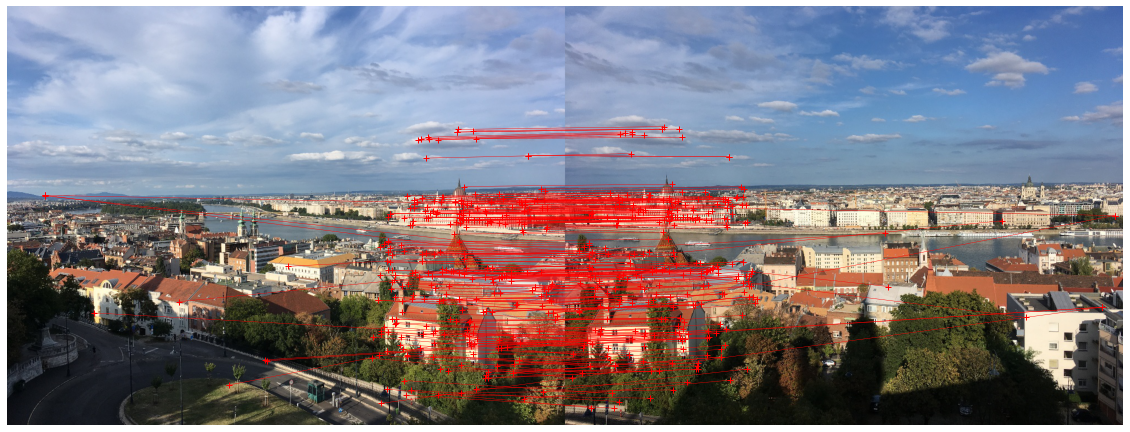

In [5]:
data = get_best_matches(img1, img2, 300)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.jpg', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

In [14]:
# display the inlier matching, report the average residual

from numpy import arange

for num_iters in range(10, 60, 10):
    for thres in arange(0.5, 2.5, 0.5):
        H, inliers, inlier_residuals = ransac(data, num_iteration=num_iters, threshold=thres)
        residual = np.average(inlier_residuals)
        ratio = len(inliers) / len(data)
        print(f"[# of iteration: {num_iters}, thres: {thres:.1f}] residual: {residual:.2f}, ratio: {ratio:.2f}")

[# of iteration: 10, thres: 0.5] residual: 0.26, ratio: 0.25
[# of iteration: 10, thres: 1.0] residual: 0.49, ratio: 0.63
[# of iteration: 10, thres: 1.5] residual: 0.61, ratio: 0.81
[# of iteration: 10, thres: 2.0] residual: 0.66, ratio: 0.89
[# of iteration: 20, thres: 0.5] residual: 0.25, ratio: 0.39
[# of iteration: 20, thres: 1.0] residual: 0.49, ratio: 0.63
[# of iteration: 20, thres: 1.5] residual: 0.58, ratio: 0.82
[# of iteration: 20, thres: 2.0] residual: 0.69, ratio: 0.90
[# of iteration: 30, thres: 0.5] residual: 0.28, ratio: 0.34
[# of iteration: 30, thres: 1.0] residual: 0.41, ratio: 0.63
[# of iteration: 30, thres: 1.5] residual: 0.59, ratio: 0.82
[# of iteration: 30, thres: 2.0] residual: 0.65, ratio: 0.89
[# of iteration: 40, thres: 0.5] residual: 0.28, ratio: 0.36
[# of iteration: 40, thres: 1.0] residual: 0.51, ratio: 0.70
[# of iteration: 40, thres: 1.5] residual: 0.60, ratio: 0.84
[# of iteration: 40, thres: 2.0] residual: 0.67, ratio: 0.89
[# of iteration: 50, thr

Average residual: 0.47
Inlier ratio: 0.68


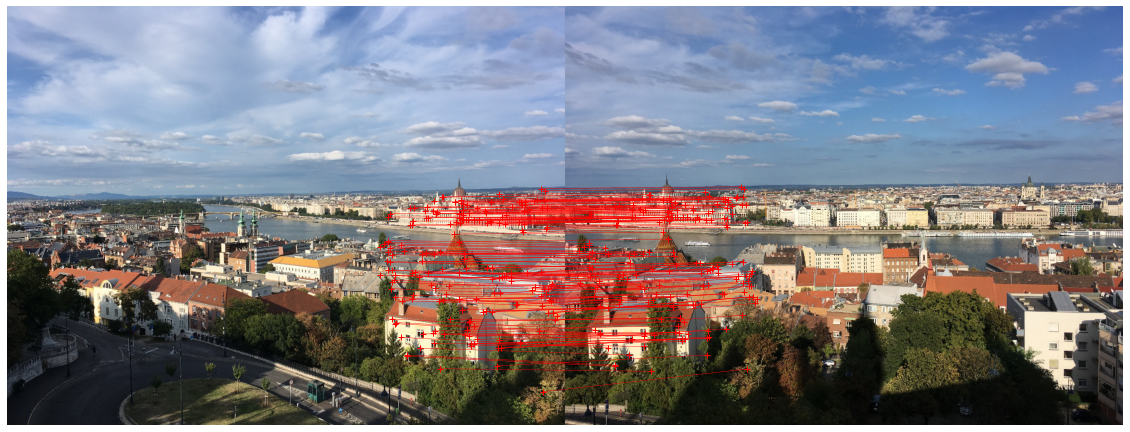

In [20]:
# display the inlier matching, report the average residual
H, inliers, inlier_residuals = ransac(data, num_iteration=50, threshold=1)
print(f"Average residual: {np.average(inlier_residuals):.2f}")
print(f"Inlier ratio: {len(inliers) / len(data):.2f}")

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, inliers)
fig.savefig('ransac_match.jpg', bbox_inches='tight')

#### Part (5) warp images to stitch them together

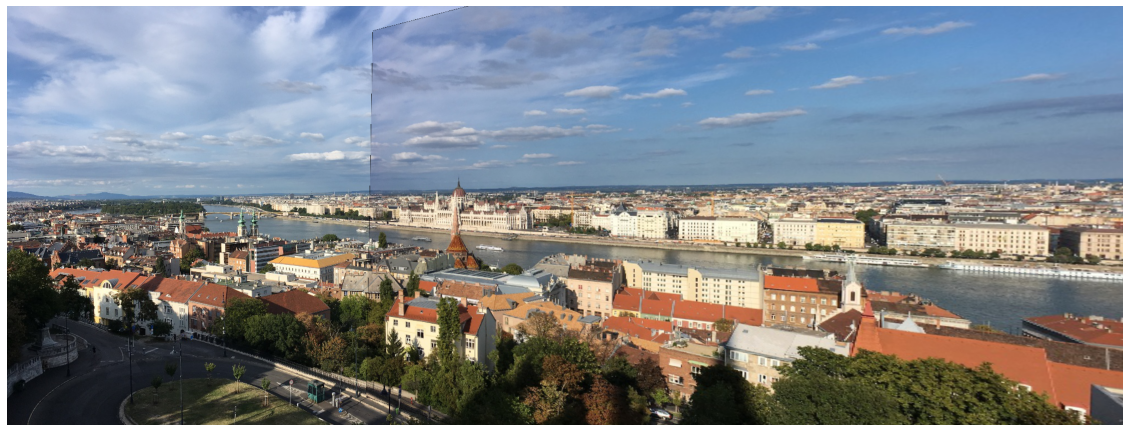

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
warp_images(ax, img1, img2, H)

# display and report the stitching results
fig.savefig('stitched_images.jpg', bbox_inches='tight')